<a href="https://colab.research.google.com/github/BenPorter165/DCGAN-Color-Image-Generation/blob/main/Abstract_art_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN Training Challenges: DCGAN for Color Images

This is a project that I started to see if I could train an AI to generate abstact art. I found much of this code from Margaret Maynard-Reid (@margaretmz) and I do not claim to own all of this code, this project was done purely for my own curiousity! I have always found image generation cool and I wanted to see how well an AI could generate different kinds of art!

I found my dataset on [Kaggle](https://www.kaggle.com/datasets/bryanb/abstract-art-gallery). The dataset contains 2782 files of abstract images and was posted by bryanb.

## Import

In [1]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt
import numpy as np

import os

Its always a good practice to check the current version of TensorFlow...

In [2]:
print(tf.version.VERSION)

2.8.0


## Data

We will train the DCGAN on a dataset called [abstract-art-gallery](https://www.kaggle.com/datasets/bryanb/abstract-art-gallery) from Kaggle, which is a collection of abstract art, scraped from https://www.wikiart.org/. 

Here is how to download Kaggle data from Colab:
* Navigate to https://www.kaggle.com. 
* Go to the [account tab](https://www.kaggle.com/me/account)  of your user profile. 
* Select "Create API Token" which triggers the download of kaggle.json, a file containing your API credentials. 
* Enter your username and Kaggle key in the cell below.

In [3]:
os.environ['KAGGLE_USERNAME']="benporter165" 
os.environ['KAGGLE_KEY']="4350c82c1aef6c1bdc09cbf1b65327aa"

In [4]:
# download kaggle dataset to 'datasets/' path
!kaggle datasets download -d bryanb/abstract-art-gallery -p datasets

100% 690M/693M [00:07<00:00, 133MB/s]
100% 693M/693M [00:07<00:00, 100MB/s]


In [5]:
!unzip datasets/abstract-art-gallery -d datasets/

Archive:  datasets/abstract-art-gallery.zip
  inflating: datasets/Abstract_gallery/Abstract_gallery/Abstract_image_0.jpg  
  inflating: datasets/Abstract_gallery/Abstract_gallery/Abstract_image_1.jpg  
  inflating: datasets/Abstract_gallery/Abstract_gallery/Abstract_image_10.jpg  
  inflating: datasets/Abstract_gallery/Abstract_gallery/Abstract_image_100.jpg  
  inflating: datasets/Abstract_gallery/Abstract_gallery/Abstract_image_1000.jpg  
  inflating: datasets/Abstract_gallery/Abstract_gallery/Abstract_image_1001.jpg  
  inflating: datasets/Abstract_gallery/Abstract_gallery/Abstract_image_1002.jpg  
  inflating: datasets/Abstract_gallery/Abstract_gallery/Abstract_image_1003.jpg  
  inflating: datasets/Abstract_gallery/Abstract_gallery/Abstract_image_1004.jpg  
  inflating: datasets/Abstract_gallery/Abstract_gallery/Abstract_image_1005.jpg  
  inflating: datasets/Abstract_gallery/Abstract_gallery/Abstract_image_1006.jpg  
  inflating: datasets/Abstract_gallery/Abstract_gallery/Abstrac

In [6]:
Abstract_gallery_dir = "/content/datasets/Abstract_gallery/Abstract_gallery"

In [7]:
train_images = tf.keras.utils.image_dataset_from_directory(
    Abstract_gallery_dir, label_mode=None, image_size=(64, 64), batch_size=32
)

Found 2782 files belonging to 1 classes.


### Visualization

Here is a visualization of the training data to get an idea of what the images look like. 

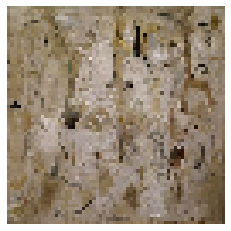

In [8]:
image_batch = next(iter(train_images))
random_index = np.random.choice(image_batch.shape[0])
random_image = image_batch[random_index].numpy().astype("int32")
plt.axis("off")
plt.imshow(random_image)
plt.show()

### Preprocessing

In [9]:
# Normalize the images to [-1, 1] which is the range of the tanh activation
train_images = train_images.map(lambda x: (x - 127.5) / 127.5)

## The Generator

Define the generator model architecture with the Keras `Sequential` API.

Use `ReLU` except for the last layer which has `tanh` as the activation.

The job of the generator is to make images, to do so in DCGAN, we feed random noise as input to the generator and upsample till the desired image size becomes 64x64x3.

In [10]:
# latent dimension of the random noise
LATENT_DIM = 100 
# weight initializer for G per DCGAN paper
WEIGHT_INIT = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02) 
# number of channels, 1 for gray scale and 3 for color images
CHANNELS = 3 # UPDATED from 1

In [11]:
def build_generator():
    # create a Keras Sequential model 
    model = Sequential(name='generator')

    # prepare for reshape: FC => BN => RN layers, note: input shape defined in the 1st Dense layer  
    model.add(layers.Dense(8 * 8 * 512, input_dim=LATENT_DIM))
    # model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    # layers.LeakyReLU(alpha=0.2),

    # 1D => 3D: reshape the output of the previous layer 
    model.add(layers.Reshape((8, 8, 512)))

    # upsample to 16x16: apply a transposed CONV => BN => RELU
    model.add(layers.Conv2DTranspose(256, (4, 4), strides=(2, 2),padding="same", kernel_initializer=WEIGHT_INIT))
    # model.add(layers.BatchNormalization())
    model.add((layers.ReLU()))

    # upsample to 32x32: apply a transposed CONV => BN => RELU
    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2),padding="same", kernel_initializer=WEIGHT_INIT))
    # model.add(layers.BatchNormalization())
    model.add((layers.ReLU()))

    # upsample to 64x64: apply a transposed CONV => BN => RELU
    model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2),padding="same", kernel_initializer=WEIGHT_INIT))
    # model.add(layers.BatchNormalization())
    model.add((layers.ReLU()))

    # final layer: Conv2D with tanh activation
    model.add(layers.Conv2D(CHANNELS, (4, 4), padding="same", activation="tanh"))

    # return the generator model
    return model

In [12]:
# build the generator model
generator = build_generator() 

In [13]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32768)             3309568   
                                                                 
 re_lu (ReLU)                (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 256)      2097408   
 nspose)                                                         
                                                                 
 re_lu_1 (ReLU)              (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 128)      524416    
 ranspose)                                               

## The Discriminator

Define the discriminator model architecture with the Keras `Sequential` API

In [14]:
def build_discriminator(height, width, depth, alpha=0.2):
    # create a Keras Sequential model
    model = Sequential(name='discriminator')
    input_shape = (height, width, depth)

    # 1. first set of CONV => BN => leaky ReLU layers
    model.add(layers.Conv2D(64, (4, 4), padding="same", strides=(2, 2),
        input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    # 2. second set of CONV => BN => leacy ReLU layers
    model.add(layers.Conv2D(128, (4, 4), padding="same", strides=(2, 2)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    # 3. third set of CONV => BN => leacy ReLU layers
    model.add(layers.Conv2D(128, (4, 4), padding="same", strides=(2, 2)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    # flatten and apply dropout
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.3))

    # sigmoid in the last layer outputting a single value for binary classification
    model.add(layers.Dense(1, activation="sigmoid"))

    # return the discriminator model
    return model

In [15]:
# build the discriminator model
discriminator = build_discriminator(64, 64, 3) 

In [16]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        3136      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)     

## DCGAN

### Define the DCGAN class
Subclass `keras.Model` and override `train_step()` to implement the DCGAN architecture. This is where the magic happens and the heart of the DCGAN implementation.

In [17]:
class DCGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):

        batch_size = tf.shape(real_images)[0]
        noise = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Step 1. Train the discriminator with both real images (label as 1) and fake images (classified as label as 0) 
        with tf.GradientTape() as tape:
            # Compute discriminator loss on real images
            pred_real = self.discriminator(real_images, training=True)
            real_labels = tf.ones((batch_size, 1))
            # UPDATED: apply one-sided label smoothing to real labels
            real_labels += 0.05 * tf.random.uniform(tf.shape(real_labels)) 
            d_loss_real = self.loss_fn(real_labels, pred_real)

            # Compute discriminator loss on fake images
            fake_images = self.generator(noise)
            pred_fake = self.discriminator(fake_images, training=True)
            fake_labels = tf.zeros((batch_size, 1))
            # UPDATED: add random noise to fake labels - not needed
            # fake_labels += 0.05 * tf.random.uniform(tf.shape(fake_labels)) 
            d_loss_fake = self.loss_fn(fake_labels, pred_fake)

            # total discriminator loss
            d_loss = (d_loss_real + d_loss_fake)/2
        # Compute discriminator gradients
        grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
        # Update discriminator weights
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_variables))

        # Step 2. Train the generator (do not update weights of the discriminator)
        misleading_labels = tf.ones((batch_size, 1)) # G wants D to think the fake images are real (label as 1)

        with tf.GradientTape() as tape:
            fake_images = self.generator(noise, training=True)
            pred_fake = self.discriminator(fake_images, training=True)
            g_loss = self.loss_fn(misleading_labels, pred_fake)
        # Compute generator gradients
        grads = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update generator wieghts
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

### Use Keras Callback to monitor training

The nice thing about overriding `train_step()` of `keras.Model()` is that we can subclass `Callback` to monitor our DCGAN training.

I use the seed noise to create images (with the generator model) throughout the training to see the progress of the generator is making. Also saved the generator model at the end of the training which could potentially be used for inference later.

In [34]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=100):
        self.num_img = num_img
        self.latent_dim = latent_dim

        # Create random noise seed for visualization during traing
        self.seed = tf.random.normal([16, latent_dim])

    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.model.generator(self.seed)
        generated_images = (generated_images * 127.5) + 127.5
        generated_images.numpy()

        fig = plt.figure(figsize=(4, 4))
        for i in range(self.num_img):
            plt.subplot(4, 4, i+1)
            img = keras.utils.array_to_img(generated_images[i]) 
            plt.imshow(img)
            plt.axis('off')
        plt.savefig('epoch_{:03d}.png'.format(epoch)) 
        plt.show()


    def on_train_end(self, logs=None):
        self.model.generator.save('generator.h5')

### The DCGAN model - putting it together

In [35]:
dcgan = DCGAN(discriminator=discriminator, generator=generator, latent_dim=LATENT_DIM)

## Compile DCGAN

Compile the dcgan model, use the `Adam` optimizer, learning rate of 0.0002, and the **Binary Cross Entropy**.

In [36]:
D_LR = 0.0001 # UPDATED: discriminator learning rate
G_LR = 0.0003 # UPDATED: generator learning rate

dcgan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=D_LR, beta_1 = 0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=G_LR, beta_1 = 0.5),  
    loss_fn=keras.losses.BinaryCrossentropy(),
)

## Train DCGAN
Now we simply call `model.fit()` to traing the dcgan model!

Epoch 1/30
87/87 [==============================] - ETA: 0s - d_loss: 0.7334 - g_loss: 0.7769

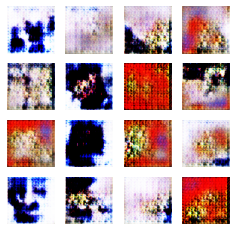

87/87 [==============================] - 15s 163ms/step - d_loss: 0.7334 - g_loss: 0.7769
Epoch 2/30
87/87 [==============================] - ETA: 0s - d_loss: 0.7222 - g_loss: 0.8033

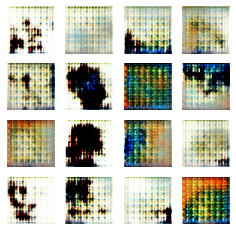

87/87 [==============================] - 15s 165ms/step - d_loss: 0.7222 - g_loss: 0.8033
Epoch 3/30
87/87 [==============================] - ETA: 0s - d_loss: 0.7115 - g_loss: 0.8249

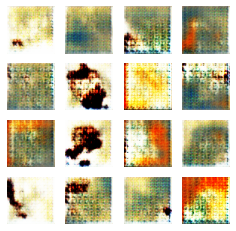

87/87 [==============================] - 16s 169ms/step - d_loss: 0.7115 - g_loss: 0.8249
Epoch 4/30
87/87 [==============================] - ETA: 0s - d_loss: 0.7408 - g_loss: 0.7853

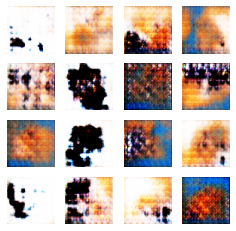

87/87 [==============================] - 16s 169ms/step - d_loss: 0.7408 - g_loss: 0.7853
Epoch 5/30
87/87 [==============================] - ETA: 0s - d_loss: 0.7090 - g_loss: 0.8193

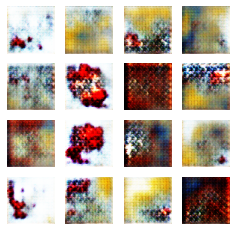

87/87 [==============================] - 15s 168ms/step - d_loss: 0.7090 - g_loss: 0.8193
Epoch 6/30
87/87 [==============================] - ETA: 0s - d_loss: 0.7051 - g_loss: 0.7686

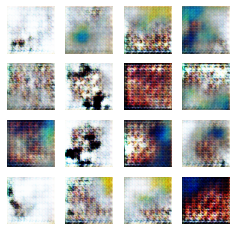

87/87 [==============================] - 15s 166ms/step - d_loss: 0.7051 - g_loss: 0.7686
Epoch 7/30
87/87 [==============================] - ETA: 0s - d_loss: 0.7171 - g_loss: 0.7757

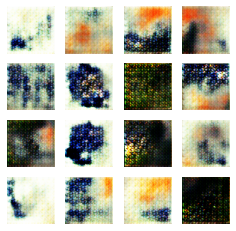

87/87 [==============================] - 16s 167ms/step - d_loss: 0.7171 - g_loss: 0.7757
Epoch 8/30
87/87 [==============================] - ETA: 0s - d_loss: 0.6977 - g_loss: 0.8219

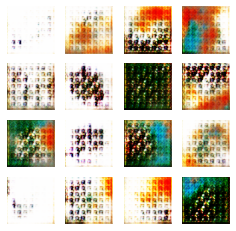

87/87 [==============================] - 16s 172ms/step - d_loss: 0.6977 - g_loss: 0.8219
Epoch 9/30
87/87 [==============================] - ETA: 0s - d_loss: 0.6990 - g_loss: 0.8245

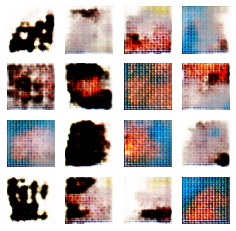

87/87 [==============================] - 16s 169ms/step - d_loss: 0.6990 - g_loss: 0.8245
Epoch 10/30
87/87 [==============================] - ETA: 0s - d_loss: 0.7072 - g_loss: 0.7882

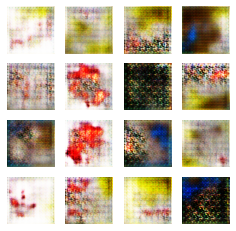

87/87 [==============================] - 16s 171ms/step - d_loss: 0.7072 - g_loss: 0.7882
Epoch 11/30
87/87 [==============================] - ETA: 0s - d_loss: 0.7117 - g_loss: 0.7770

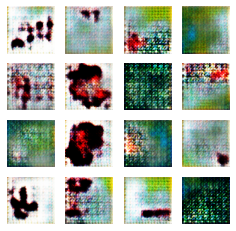

87/87 [==============================] - 16s 170ms/step - d_loss: 0.7117 - g_loss: 0.7770
Epoch 12/30
87/87 [==============================] - ETA: 0s - d_loss: 0.7059 - g_loss: 0.7854

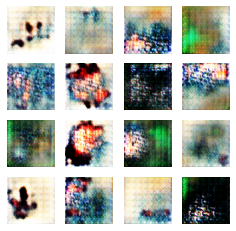

87/87 [==============================] - 16s 174ms/step - d_loss: 0.7059 - g_loss: 0.7854
Epoch 13/30
87/87 [==============================] - ETA: 0s - d_loss: 0.7168 - g_loss: 0.8119

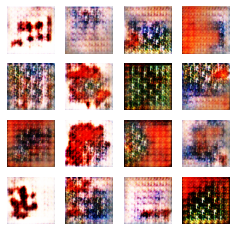

87/87 [==============================] - 16s 170ms/step - d_loss: 0.7168 - g_loss: 0.8119
Epoch 14/30
87/87 [==============================] - ETA: 0s - d_loss: 0.7245 - g_loss: 0.7622

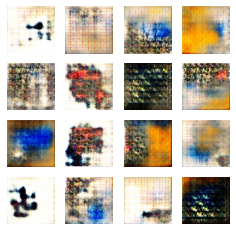

87/87 [==============================] - 16s 172ms/step - d_loss: 0.7245 - g_loss: 0.7622
Epoch 15/30
87/87 [==============================] - ETA: 0s - d_loss: 0.7114 - g_loss: 0.7663

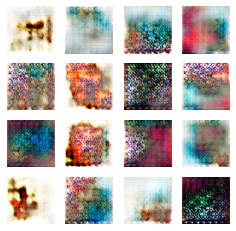

87/87 [==============================] - 16s 173ms/step - d_loss: 0.7114 - g_loss: 0.7663
Epoch 16/30
87/87 [==============================] - ETA: 0s - d_loss: 0.7126 - g_loss: 0.7386

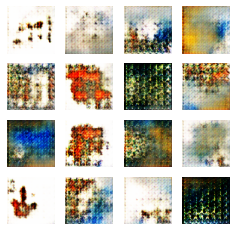

87/87 [==============================] - 16s 178ms/step - d_loss: 0.7126 - g_loss: 0.7386
Epoch 17/30
87/87 [==============================] - ETA: 0s - d_loss: 0.7038 - g_loss: 0.7643

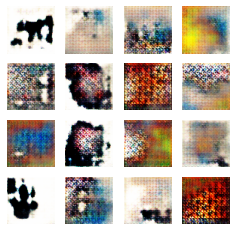

87/87 [==============================] - 16s 174ms/step - d_loss: 0.7038 - g_loss: 0.7643
Epoch 18/30
87/87 [==============================] - ETA: 0s - d_loss: 0.7076 - g_loss: 0.7680

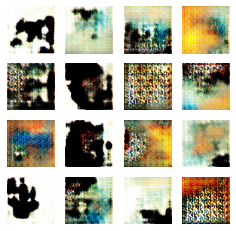

87/87 [==============================] - 16s 173ms/step - d_loss: 0.7076 - g_loss: 0.7680
Epoch 19/30
87/87 [==============================] - ETA: 0s - d_loss: 0.7060 - g_loss: 0.7505

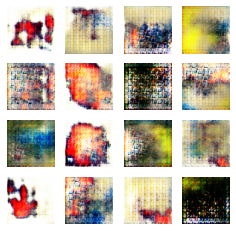

87/87 [==============================] - 16s 173ms/step - d_loss: 0.7060 - g_loss: 0.7505
Epoch 20/30
87/87 [==============================] - ETA: 0s - d_loss: 0.7055 - g_loss: 0.7488

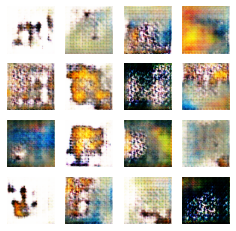

87/87 [==============================] - 16s 175ms/step - d_loss: 0.7055 - g_loss: 0.7488
Epoch 21/30
87/87 [==============================] - ETA: 0s - d_loss: 0.7064 - g_loss: 0.7729

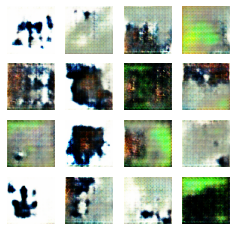

87/87 [==============================] - 17s 180ms/step - d_loss: 0.7064 - g_loss: 0.7729
Epoch 22/30
87/87 [==============================] - ETA: 0s - d_loss: 0.6998 - g_loss: 0.7699

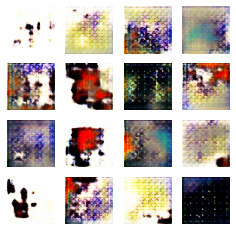

87/87 [==============================] - 16s 178ms/step - d_loss: 0.6998 - g_loss: 0.7699
Epoch 23/30
87/87 [==============================] - ETA: 0s - d_loss: 0.6973 - g_loss: 0.7825

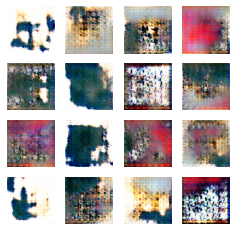

87/87 [==============================] - 16s 177ms/step - d_loss: 0.6973 - g_loss: 0.7825
Epoch 24/30
87/87 [==============================] - ETA: 0s - d_loss: 0.6978 - g_loss: 0.7908

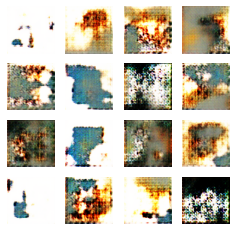

87/87 [==============================] - 17s 181ms/step - d_loss: 0.6978 - g_loss: 0.7908
Epoch 25/30
87/87 [==============================] - ETA: 0s - d_loss: 0.6965 - g_loss: 0.7650

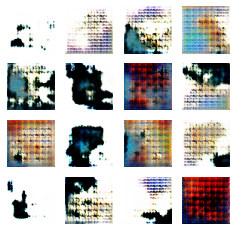

87/87 [==============================] - 17s 183ms/step - d_loss: 0.6965 - g_loss: 0.7650
Epoch 26/30
87/87 [==============================] - ETA: 0s - d_loss: 0.6957 - g_loss: 0.7971

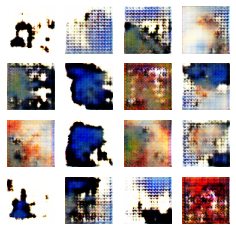

87/87 [==============================] - 17s 180ms/step - d_loss: 0.6957 - g_loss: 0.7971
Epoch 27/30
87/87 [==============================] - ETA: 0s - d_loss: 0.6953 - g_loss: 0.7944

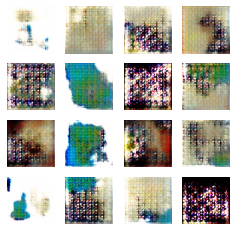

87/87 [==============================] - 17s 181ms/step - d_loss: 0.6953 - g_loss: 0.7944
Epoch 28/30
87/87 [==============================] - ETA: 0s - d_loss: 0.7044 - g_loss: 0.7829

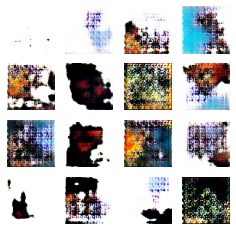

87/87 [==============================] - 17s 182ms/step - d_loss: 0.7044 - g_loss: 0.7829
Epoch 29/30
87/87 [==============================] - ETA: 0s - d_loss: 0.7096 - g_loss: 0.7585

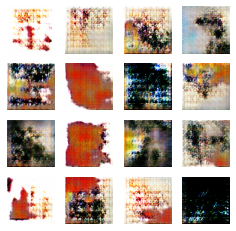

87/87 [==============================] - 17s 186ms/step - d_loss: 0.7096 - g_loss: 0.7585
Epoch 30/30
87/87 [==============================] - ETA: 0s - d_loss: 0.6944 - g_loss: 0.7609

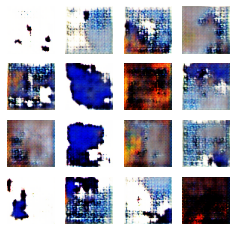

87/87 [==============================] - 17s 185ms/step - d_loss: 0.6944 - g_loss: 0.7609


In [38]:
NUM_EPOCHS = 30 # number of epochs
dcgan.fit(train_images, epochs=NUM_EPOCHS, callbacks=[GANMonitor(num_img=16, latent_dim=LATENT_DIM)])